In [1]:
import sys
sys.path.append('..')


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()

'/home/borge/spiral_arms/George'

In [3]:
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [4]:
# This has to be defined locally - not being lazy

def get_variable_from_name(name):
    # Create a list of all the defined variables
    var_dict = globals() 
    
    # Get the variables from the list
    var_value = var_dict.get(name)
    
    return var_value        

In [5]:
# What we want to do is calculate the ammount of flux from the FICL isolated image as a fraction of the flux from the original image

# So we will work on a test set of 10 Images
candidate_list = np.loadtxt('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/directories.txt',dtype=str)
#candidate_list = candidate_list[:len(bands)*10]

for i in range(len(candidate_list)):
    candidate_list[i] = candidate_list[i][:-2]

candidate_list = np.unique(candidate_list)
#candidate_list = candidate_list[:10]

failures = ['588023670779281517','587742573761855511','587739720303181999',
           '587744729298239519','587731173306663288','587735349099954195']
failure_mask = np.isin(candidate_list, failures)
candidate_list = candidate_list[~failure_mask]

# create an array of the candidate identifiers
identifiers = np.empty_like(candidate_list)
for i in range(len(candidate_list)):
    x = candidate_list[i]
    identifiers[i] = x[-4:]
    
candidate_list.shape



(94,)

In [6]:
# Go and get these ten FICL processed images and save them to variables 

for i in range(0,len(candidate_list)):
    exec('tab_{},comp_{} = gfits.Composite_from_directory_raid("{}","/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/")'.format(identifiers[i],identifiers[i],candidate_list[i]),globals())

In [7]:
# Now go and get the originals from the Bright Spiral folder
for i in range(0,len(candidate_list)):
    exec('comp_org_{} = gfits.Read_M_band({},"/home/borge/Data/Brightest_1000/Brightest_1000_Spirals/")'.format(identifiers[i],candidate_list[i]),globals())


In [8]:
# Create lists of the variables that have been created
comp_org_arr = np.empty_like(candidate_list)
comp_arr = np.empty_like(candidate_list)
tab_arr = np.empty_like(candidate_list)


for i in range(0,len(identifiers)):
    comp_org_arr[i] = 'comp_org_{}'.format(identifiers[i])
    comp_arr[i] = 'comp_{}'.format(identifiers[i])
    tab_arr[i] = 'tab_{}'.format(identifiers[i])
    
#comp_org_arr, tab_arr, comp_arr
    

In [9]:
def list_empty_directories(folder_path):
    empty_dirs = []
    for dirpath, dirnames, filenames in os.walk(folder_path):
        if not dirnames and not filenames:
            empty_dirs.append(dirpath)
    return empty_dirs

fail_arr = list_empty_directories('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23')
fail_arr

['/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/588023670779281517ua',
 '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587742573761855511ua',
 '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587739720303181999ua',
 '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587744729298239519ua',
 '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587731173306663288ia',
 '/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587735349099954195ra']

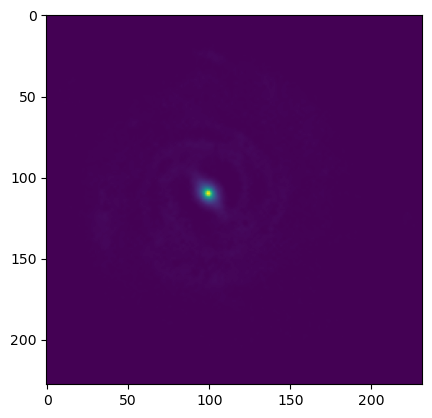

In [10]:
plt.imshow(comp_0766[:,:,1])

In [11]:
# First write this into a new function
def flux_fraction(Image,Table,Original_Image):
    
    if np.any(Image) == np.nan:
        print('Found a Nan')
        return np.nan
    else:
        # First apply the bulge mask to the FICL process image
        masked_Image = gfits.R_e_bulge_mask(Image,Table)
        
        # Set background for SDSS images
        background = 1000
        
        # Calculate fraction of flux in the masked to original image
        flux_fraction  = np.sum(masked_Image)/np.sum(Original_Image-background)
        
        return flux_fraction
        
    

In [12]:
comp_nan = get_variable_from_name(candidate_list[14])
candidate_list[9]

'587726102021668984'

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

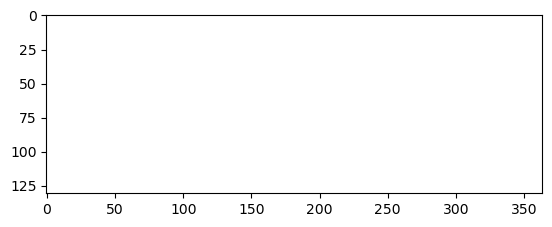

In [13]:
test = gfits.Read('/home/borge/Data/MLIS1_Output/01_04_23/Output_01_04_23/587726102021668984ua/0200/small_nonpar.fits')
plt.imshow(test)
test

In [14]:
# Now we need to generalise this and write it into an array candiates X bands

flux_fractions_all_bands = np.empty((len(candidate_list),len(bands)))

for i in range(0,len(candidate_list)):
    for s in range(0,len(bands)):
        print(i)
        current_tab = get_variable_from_name(tab_arr[i])
        current_comp = get_variable_from_name(comp_arr[i])
        current_comp_org = get_variable_from_name(comp_org_arr[i])
        #print(current_comp[:,:,s],current_tab[s],current_comp_org[:,:,s])
        flux_fractions_all_bands[i,s] = flux_fraction(current_comp[:,:,s],current_tab[s],current_comp_org[:,:,s])

0
47.214117862764446 [[118 140]]
0
407.73884997278736 [[119 140]]
0
692.8907795885721 [[119 140]]
0
699.1344905930076 [[120 140]]
0
248.96525804533186 [[119 140]]
1
130.9704659789968 [[122  45]]
1
1045.2647055875502 [[122  45]]
1
1594.8733651792345 [[121  45]]
1
1847.0195719729163 [[121  45]]
1
387.572095719177 [[121  45]]
2
56.60523614613667 [[106 104]]
2
647.4748993064467 [[105 104]]
2
777.2568595925746 [[106 104]]
2
879.2576957574743 [[106 104]]
2
218.07483625796715 [[106 104]]
3
216.12563486374071 [[96 78]]
3
1408.7999819077918 [[95 79]]
3
1820.2708764033662 [[96 79]]
3
2050.471647865054 [[96 78]]
3
480.1187702503917 [[96 78]]
4
44.42182647064515 [[76 84]]
4
529.0708236622515 [[76 84]]
4
922.684757523193 [[76 84]]
4
1139.3058356696083 [[76 83]]
4
258.4144674602247 [[75 84]]
5
75.51895515790147 [[80 58]]
5
1007.4681874929554 [[80 58]]
5
2330.0002918564896 [[80 58]]
5
2648.6730961592675 [[79 57]]
5
921.6643640444989 [[79 58]]
6
56.71990574747035 [[108 118]]
6
517.1290129981211 [[107 

/home/borge/spiral_arms/George/gax_fits.py:154: RuntimeWarning: All-NaN slice encountered
  bulge_intensity = np.nanmax(image)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
flux_fractions_all_bands[:,-4:] # None above 1 - Nice

array([[6.90447128e-310, 4.67083464e-310, 4.67083464e-310,
        0.00000000e+000],
       [4.67083929e-310, 4.67083929e-310, 6.90433771e-310,
        0.00000000e+000],
       [8.48798316e-314, 6.90433771e-310, 6.90447095e-310,
        6.90447092e-310],
       [6.90447095e-310, 6.90447094e-310, 6.90447093e-310,
        6.90447093e-310],
       [6.90447101e-310, 6.90447093e-310, 6.90447093e-310,
        6.90447101e-310],
       [6.90447093e-310, 6.90447095e-310, 6.90447092e-310,
        6.90447093e-310],
       [6.90447101e-310, 6.90447095e-310, 6.90447093e-310,
        6.90447093e-310],
       [6.90447095e-310, 6.90447093e-310, 6.90447101e-310,
        6.90447101e-310],
       [6.90447093e-310, 6.90447095e-310, 6.90447101e-310,
        6.90447092e-310],
       [6.90447101e-310, 6.90447093e-310, 6.90447092e-310,
        6.90447092e-310],
       [6.90447093e-310, 6.90447093e-310, 6.90447095e-310,
        6.90447093e-310],
       [6.90447101e-310, 6.90447093e-310, 6.90447087e-310,
      

In [ ]:
flux_fractions_all_bands

array([[6.90447128e-310, 6.90447128e-310, 4.67083464e-310,
        4.67083464e-310, 0.00000000e+000],
       [0.00000000e+000, 4.67083929e-310, 4.67083929e-310,
        6.90433771e-310, 0.00000000e+000],
       [3.95252517e-323, 8.48798316e-314, 6.90433771e-310,
        6.90447095e-310, 6.90447092e-310],
       [6.90447092e-310, 6.90447095e-310, 6.90447094e-310,
        6.90447093e-310, 6.90447093e-310],
       [6.90447093e-310, 6.90447101e-310, 6.90447093e-310,
        6.90447093e-310, 6.90447101e-310],
       [6.90447101e-310, 6.90447093e-310, 6.90447095e-310,
        6.90447092e-310, 6.90447093e-310],
       [6.90447101e-310, 6.90447101e-310, 6.90447095e-310,
        6.90447093e-310, 6.90447093e-310],
       [6.90447092e-310, 6.90447095e-310, 6.90447093e-310,
        6.90447101e-310, 6.90447101e-310],
       [6.90447092e-310, 6.90447093e-310, 6.90447095e-310,
        6.90447101e-310, 6.90447092e-310],
       [6.90447095e-310, 6.90447101e-310, 6.90447093e-310,
        6.90447092e-310